#### Data Preprocessing
1. Extract pose sequences from each video
2. Split into train, val, and test based on class label

In [6]:
import cv2
import mediapipe as mp
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

mp_pose = mp.solutions.pose

def extract_normalized_post_sequence(video_path, max_frames=100):
    cap = cv2.VideoCapture(str(video_path))
    post = mp_pose.Pose(static_image_mode=False)
    sequence = []
    
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = post.process(image_rgb)
        if results.pose_landmarks:
            keypoints = []
            for lm in results.pose_landmarks.landmark:
                keypoints.extend([lm.x, lm.y])
            sequence.append(keypoints)
    cap.release()
    
    # Normalize by centering on hips and scaling by shoulder width
    sequence = np.array(sequence)
    if len(sequence) == 0:
        return None
    sequence = sequence.reshape(sequence.shape[0], 33, 2)
    
    center = (sequence[:, 23] + sequence[:, 24]) / 2
    sequence -= center[:, None, :]
    shoulder_width = np.linalg.norm(sequence[:, 11] - sequence[:, 12], axis=1) + 1e-8
    sequence /= shoulder_width[:, None, None]
    sequence = sequence.reshape(sequence.shape[0], -1)
    
    # Pad or truncate to max_frames
    if sequence.shape[0] > max_frames:
        sequence = sequence[:max_frames]
    elif sequence.shape[0] < max_frames:
        padding = np.zeros((max_frames - sequence.shape[0], sequence.shape[1]))
        sequence = np.vstack([sequence, padding])
    
    return sequence

def process_and_save_videos(input_dir, output_dir, subset_name, max_frames=100):
    metadata = []
    
    input_dir = Path(input_dir)
    output_dir = Path(output_dir) / subset_name
    output_dir.mkdir(parents=True, exist_ok=True)
    
    for category_dir in input_dir.iterdir():
        if not category_dir.is_dir():
            continue
        category = category_dir.name
        save_path = output_dir / category
        # skip category if the directory exists
        if save_path.exists():
            continue
        save_path.mkdir(parents=True, exist_ok=True)
        
        for video_file in tqdm(list(category_dir.glob("*.mp4")), desc=f"{subset_name}/{category}"):
            pose_seq = extract_normalized_post_sequence(video_file, max_frames)
            if pose_seq is not None:
                save_name = video_file.stem + '.npy'
                np.save(save_path / save_name, pose_seq)
                metadata.append({
                    'video': str(video_file),
                    'category': category,
                    'pose_sequence': save_name
                })
    return metadata

In [ ]:
# Start by processing the two directories into train and train2
data_dir = "gym-workoutexercises-video/verified_data/verified_data"
btc_dir = data_dir + "/data_btc_10s"
crawl_dir = data_dir + "/data_crawl_10s"
save_dir = "pose_data"

process_and_save_videos(btc_dir, save_dir, "train", max_frames=100)
process_and_save_videos(crawl_dir, save_dir, "train2", max_frames=100)

In [ ]:
# Process test set
data_dir = "gym-workoutexercises-video/test/test"
save_dir = "pose_data"
process_and_save_videos(data_dir, save_dir, "test", max_frames=100)

test/deadlift:   0%|          | 0/2 [00:00<?, ?it/s]I0000 00:00:1745024143.388252 17922020 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3
W0000 00:00:1745024143.449844 17931152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745024143.460881 17931158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
test/deadlift:  50%|█████     | 1/2 [00:06<00:06,  6.96s/it]I0000 00:00:1745024150.329500 17922020 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3
W0000 00:00:1745024150.388316 17931335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745024150.396897 17931335 inference_feedback_manager.cc:114] Feedback manager requires a model with 

[{'video': 'gym-workoutexercises-video/test/test/deadlift/video4.mp4',
  'category': 'deadlift',
  'pose_sequence': 'video4.npy'},
 {'video': 'gym-workoutexercises-video/test/test/deadlift/deadlift_1.mp4',
  'category': 'deadlift',
  'pose_sequence': 'deadlift_1.npy'},
 {'video': 'gym-workoutexercises-video/test/test/hammer curl/video6.mp4',
  'category': 'hammer curl',
  'pose_sequence': 'video6.npy'},
 {'video': 'gym-workoutexercises-video/test/test/hammer curl/hammer curl_1.mp4',
  'category': 'hammer curl',
  'pose_sequence': 'hammer curl_1.npy'},
 {'video': 'gym-workoutexercises-video/test/test/hammer curl/hammer curl_2.mp4',
  'category': 'hammer curl',
  'pose_sequence': 'hammer curl_2.npy'},
 {'video': 'gym-workoutexercises-video/test/test/tricep Pushdown/tricep pushdown_1.mp4',
  'category': 'tricep Pushdown',
  'pose_sequence': 'tricep pushdown_1.npy'},
 {'video': 'gym-workoutexercises-video/test/test/tricep Pushdown/video22.mp4',
  'category': 'tricep Pushdown',
  'pose_sequ

In [ ]:
import random
import shutil

def combine_and_split_data(source_dirs, target_base, split_ratio=0.8):
    target_base = Path(target_base)
    
    all_samples = {}
    for source in source_dirs:
        for class_dir in Path(source).iterdir():
            if not class_dir.is_dir():
                continue
            label = class_dir.name
            if label not in all_samples:
                all_samples[label] = []
            for npy_file in class_dir.glob("*.npy"):
                all_samples[label].append(npy_file)    
    
    train_samples = []
    val_samples = []
    
    for label, files in all_samples.items():
        random.shuffle(files)
        split_index = int(len(files) * split_ratio)
        train_files = files[:split_index]
        val_files = files[split_index:]
        train_samples.extend([(f, label) for f in train_files])
        val_samples.extend([(f, label) for f in val_files])
        
    for subset, samples in [("train", train_samples), ("val", val_samples)]:
        for npy_file, label in tqdm(samples, desc=f"Copying {subset}"):
            dest_dir = Path(target_base) / subset / label
            dest_dir.mkdir(parents=True, exist_ok=True)
            shutil.copy(npy_file, dest_dir / npy_file.name)
    print(f"Copied {len(train_samples)} training samples and {len(val_samples)} validation samples.")

In [ ]:
# Combine both train directories and randomly split into train and val
combine_and_split_data(["pose_data/train1", "pose_data/train2"], "pose_data", split_ratio=0.8)

Copying val: 100%|██████████| 325/325 [00:00<00:00, 1814.85it/s]

Copied 1246 training samples and 325 validation samples.


In [ ]:
# Build a metadata file for the dataset
def build_metadata(root_dir="post_data"):
    metadata = []
    root_path = Path(root_dir)
    for subset in root_path.iterdir():
        if not subset.is_dir():
            continue
        for category in subset.iterdir():
            if not category.is_dir():
                continue
            for npy_file in category.glob("*.npy"):
                metadata.append({
                    'video': str(npy_file),
                    'category': category.name,
                    'pose_sequence': npy_file.name,
                    'subset': subset.name,
                })
    return pd.DataFrame(metadata)

metadata_df = build_metadata("pose_data")
metadata_df.to_csv("pose_data/metadata.csv", index=False)

#### Supervised Classifier

Visualize class distribution:

In [76]:
# Load metadata and check distribution
df = pd.read_csv("pose_data/metadata.csv")
train = df[df['subset'] == 'train']
temp = df[df['subset'] == 'val']

# split temp into val and test
val = temp.sample(frac=0.85, random_state=42)
test = temp.drop(val.index)

dist_matrix = pd.crosstab(df['category'], df['subset'])
dist_matrix

print(train.shape, val.shape, test.shape)

(1245, 4) (276, 4) (49, 4)


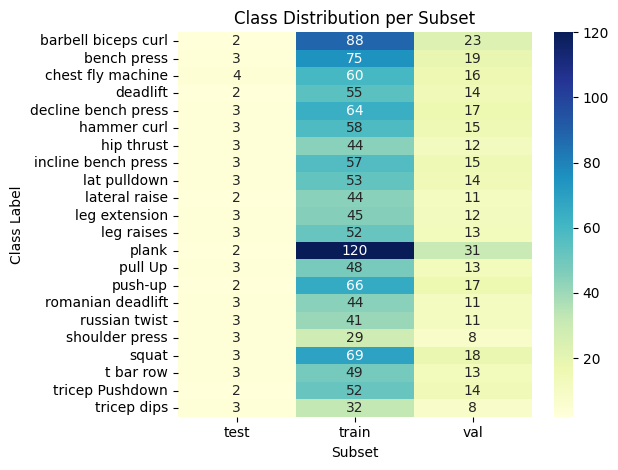

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Look at class distribution
sns.heatmap(dist_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Class Distribution per Subset")
plt.ylabel("Class Label")
plt.xlabel("Subset")
plt.tight_layout()
plt.show()

In [78]:
def load_dataset(df):
    X, y = [], []
    for _, row in df.iterrows():
        pose = np.load(row['video'])
        X.append(pose)
        y.append(row['category'])
    return np.array(X), np.array(y)

In [79]:
from sklearn.preprocessing import LabelEncoder

# Load datasets
X_train, y_train = load_dataset(train)
X_val, y_val = load_dataset(val)
X_test, y_test = load_dataset(test)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

label_names = le.classes_
print(X_train.shape, y_train_enc.shape)

(1245, 100, 66) (1245,)


Random Forest:

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train a baseline Random Forest classifier
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train_enc)
y_pred = rf.predict(X_val_flat)
print("Validation Accuracy:", accuracy_score(y_val_enc, y_pred))
print(classification_report(y_val_enc, y_pred, target_names=label_names))

Validation Accuracy: 0.8188405797101449
                     precision    recall  f1-score   support

barbell biceps curl       0.73      0.80      0.76        20
        bench press       0.93      0.82      0.88        17
  chest fly machine       0.74      1.00      0.85        14
           deadlift       0.62      0.62      0.62        13
decline bench press       0.80      0.62      0.70        13
        hammer curl       0.75      0.69      0.72        13
         hip thrust       0.79      1.00      0.88        11
incline bench press       0.92      0.85      0.88        13
       lat pulldown       0.77      1.00      0.87        10
      lateral raise       0.91      0.91      0.91        11
      leg extension       1.00      0.82      0.90        11
         leg raises       0.90      0.69      0.78        13
              plank       0.89      1.00      0.94        24
            pull Up       1.00      0.70      0.82        10
            push-up       0.84      1.00    

1D CNN:

In [81]:
from tensorflow.keras import layers, models
import tensorflow as tf

input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(label_names)

model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
    layers.Conv1D(128, 5, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),
    
    layers.Conv1D(128, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.3),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
callbacks = [tf.keras.callbacks.ModelCheckpoint('pose_model.keras', save_best_only=True, monitor='val_loss', mode='min')]
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train_enc, epochs=200, batch_size=32, validation_data=(X_val, y_val_enc), callbacks=callbacks)

Epoch 1/200


/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0782 - loss: 4.4939 - val_accuracy: 0.2210 - val_loss: 2.8636
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1805 - loss: 2.8410 - val_accuracy: 0.3152 - val_loss: 2.5866
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2811 - loss: 2.5519 - val_accuracy: 0.3913 - val_loss: 2.4062
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3339 - loss: 2.3334 - val_accuracy: 0.3986 - val_loss: 2.1424
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3516 - loss: 2.2691 - val_accuracy: 0.3949 - val_loss: 2.0551
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3897 - loss: 2.0992 - val_accuracy: 0.4746 - val_loss: 1.8913
Epoch 7/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3882 - loss: 1.9912 - val_accuracy: 0.5000 - val_loss: 1.8408
Epoch 8/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4175 - loss: 1.8776 - val_accuracy: 0.4964 - val_loss: 1.

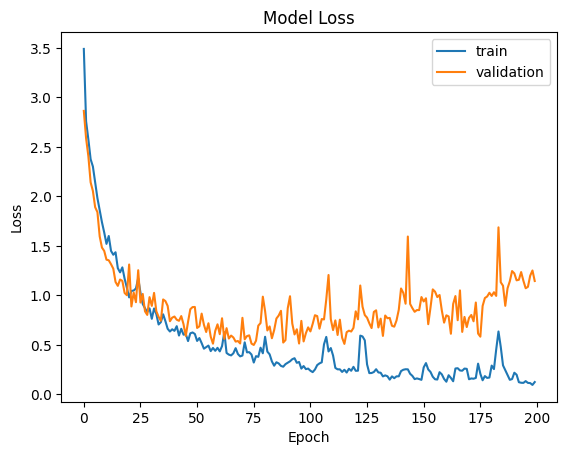

In [82]:
# Plot train vs. validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


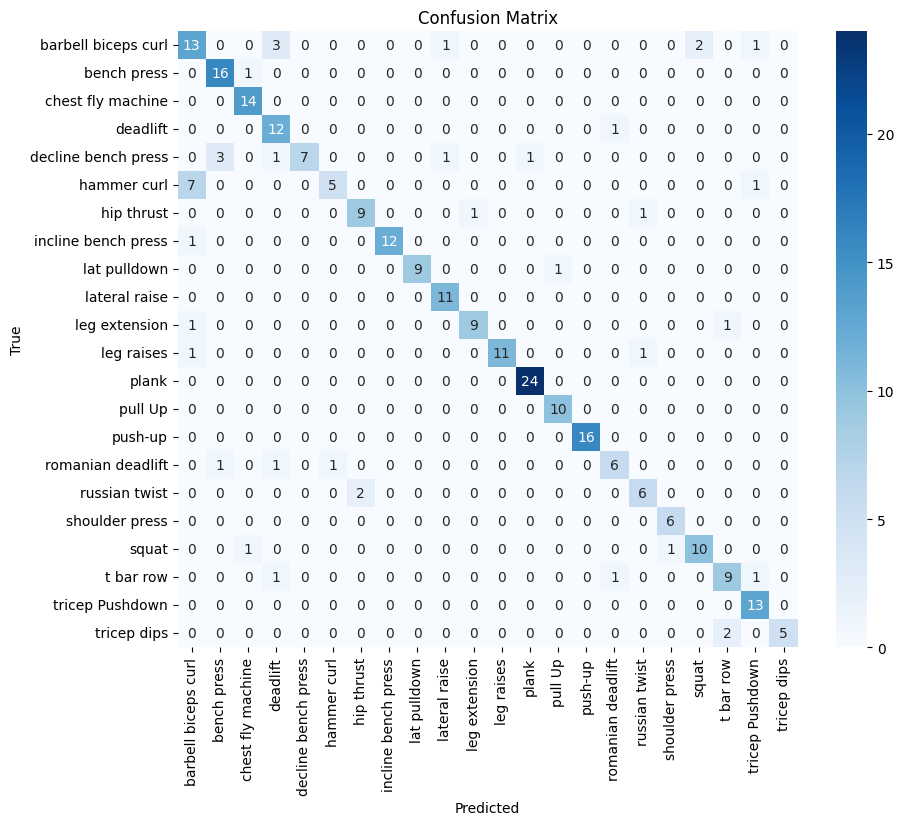

In [83]:
from sklearn.metrics import confusion_matrix

# Evaluate on validation set and explore misclassifications
model = models.load_model('pose_model.keras')
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_true_labels = le.inverse_transform(y_val_enc)
y_pred_labels = le.inverse_transform(y_val_pred_classes)

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

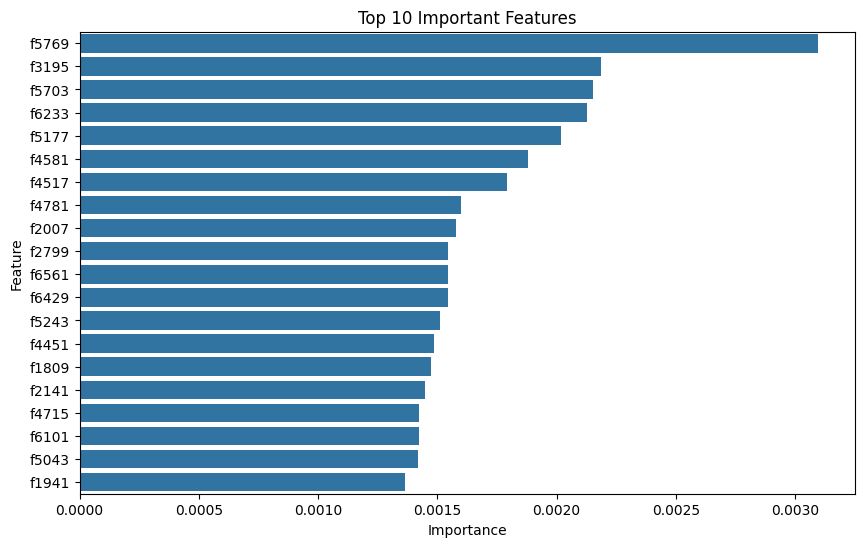

   Feature  Importance
0    f5769    0.003095
1    f3195    0.002187
2    f5703    0.002151
3    f6233    0.002127
4    f5177    0.002018
5    f4581    0.001880
6    f4517    0.001790
7    f4781    0.001598
8    f2007    0.001579
9    f2799    0.001546
10   f6561    0.001544
11   f6429    0.001543
12   f5243    0.001510
13   f4451    0.001485
14   f1809    0.001474
15   f2141    0.001449
16   f4715    0.001424
17   f6101    0.001421
18   f5043    0.001418
19   f1941    0.001363


In [84]:
importances = rf.feature_importances_  # shape: (num_features,)
top_indices = np.argsort(importances)[-20:][::-1]
feature_names = [f"f{i}" for i in range(len(importances))]  # Replace with actual names if you have them
top_features = [(feature_names[i], importances[i]) for i in top_indices]
top_df = pd.DataFrame(top_features, columns=["Feature", "Importance"])

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=top_df)
plt.title("Top 10 Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
print(top_df)

In [85]:
def decode_feature(index, num_features=66):
    frame = index // num_features
    feat = index % num_features
    joint = feat // 2
    coord = 'x' if feat % 2 == 0 else 'y'
    return f"Frame {frame}, Joint {joint}, Coord {coord}"

top_indices = [5769, 3195, 5703, 6233, 5177, 4581, 4517, 4781, 2007, 2799, 6561, 6429, 5243, 4451, 1809, 2141, 4715, 6101, 5043, 1941]
for i in top_indices:
    print(f"f{i} → {decode_feature(i)}")

f5769 → Frame 87, Joint 13, Coord y
f3195 → Frame 48, Joint 13, Coord y
f5703 → Frame 86, Joint 13, Coord y
f6233 → Frame 94, Joint 14, Coord y
f5177 → Frame 78, Joint 14, Coord y
f4581 → Frame 69, Joint 13, Coord y
f4517 → Frame 68, Joint 14, Coord y
f4781 → Frame 72, Joint 14, Coord y
f2007 → Frame 30, Joint 13, Coord y
f2799 → Frame 42, Joint 13, Coord y
f6561 → Frame 99, Joint 13, Coord y
f6429 → Frame 97, Joint 13, Coord y
f5243 → Frame 79, Joint 14, Coord y
f4451 → Frame 67, Joint 14, Coord y
f1809 → Frame 27, Joint 13, Coord y
f2141 → Frame 32, Joint 14, Coord y
f4715 → Frame 71, Joint 14, Coord y
f6101 → Frame 92, Joint 14, Coord y
f5043 → Frame 76, Joint 13, Coord y
f1941 → Frame 29, Joint 13, Coord y


In [86]:
# Attempt to increase accuracy by adding shoulder -> elbow joints twice
joint_indices = [12, 13, 14, 15]

def extract_joint_features(sequence):
    """
    Input: sequence of shape (frames, 66)
    Output: sequence of shape (frames, selected_joints × 2)
    """
    sequence = sequence.reshape(sequence.shape[0], 33, 2)  # → (frames, joints, 2)
    wrist_joints = sequence[:, joint_indices, :]         # → (frames, selected_joints, 2)
    return wrist_joints.reshape(sequence.shape[0], -1)        # → (frames, selected_joints * 2)


In [87]:
from tensorflow.keras import Input

# Fit the same CNN architecure but with the new joint features
X_train_joints = np.array([extract_joint_features(seq) for seq in X_train])
X_train_joints = np.concatenate((X_train, X_train_joints), axis=-1)
X_val_joints = np.array([extract_joint_features(seq) for seq in X_val])
X_val_joints = np.concatenate((X_val, X_val_joints), axis=-1)

input_shape = (X_train_joints.shape[1], X_train_joints.shape[2])
inputs = Input(shape=input_shape)

# Conv branch
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.Conv1D(128, 5, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)

# Dense layers
x = layers.Dense(128, activation='relu', name='embedding')(x)  # This is where you'll extract features
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Build model
joints_model = models.Model(inputs=inputs, outputs=outputs)
joints_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = joints_model.fit(X_train_joints, y_train_enc, epochs=200, batch_size=32, validation_data=(X_val_joints, y_val_enc), callbacks=callbacks)

joints_model = models.load_model('pose_model_joints.keras')
y_val_pred_joints = joints_model.predict(X_val_joints)
y_val_pred_classes_joints = np.argmax(y_val_pred_joints, axis=1)
y_true_labels_joints = le.inverse_transform(y_val_enc)
y_pred_labels_joints = le.inverse_transform(y_val_pred_classes_joints)

Epoch 1/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0931 - loss: 3.8911 - val_accuracy: 0.2246 - val_loss: 2.7688
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1822 - loss: 2.7804 - val_accuracy: 0.2862 - val_loss: 2.5508
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2755 - loss: 2.5384 - val_accuracy: 0.3080 - val_loss: 2.1598
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2907 - loss: 2.4355 - val_accuracy: 0.4529 - val_loss: 2.1100
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3503 - loss: 2.1497 - val_accuracy: 0.4928 - val_loss: 1.9493
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3940 - loss: 2.0015 - val_accuracy: 0.5145 - val_loss: 1.7369
Epoch 7/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4118 - loss: 1.9342 - val_accuracy: 0.5290 - val_loss: 1.6950
Epoch 8/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4117 - loss: 1.8591 - val_accuracy: 0.5217

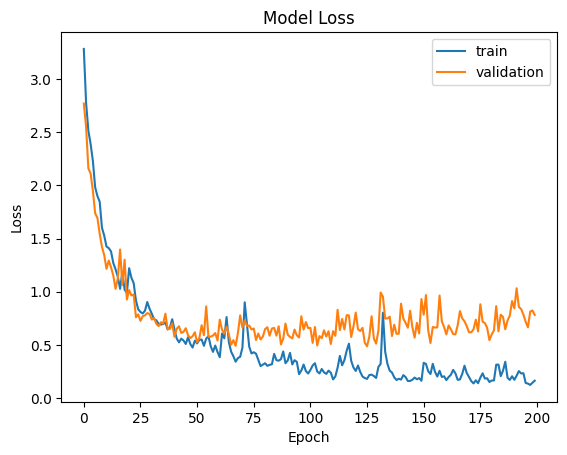

In [88]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

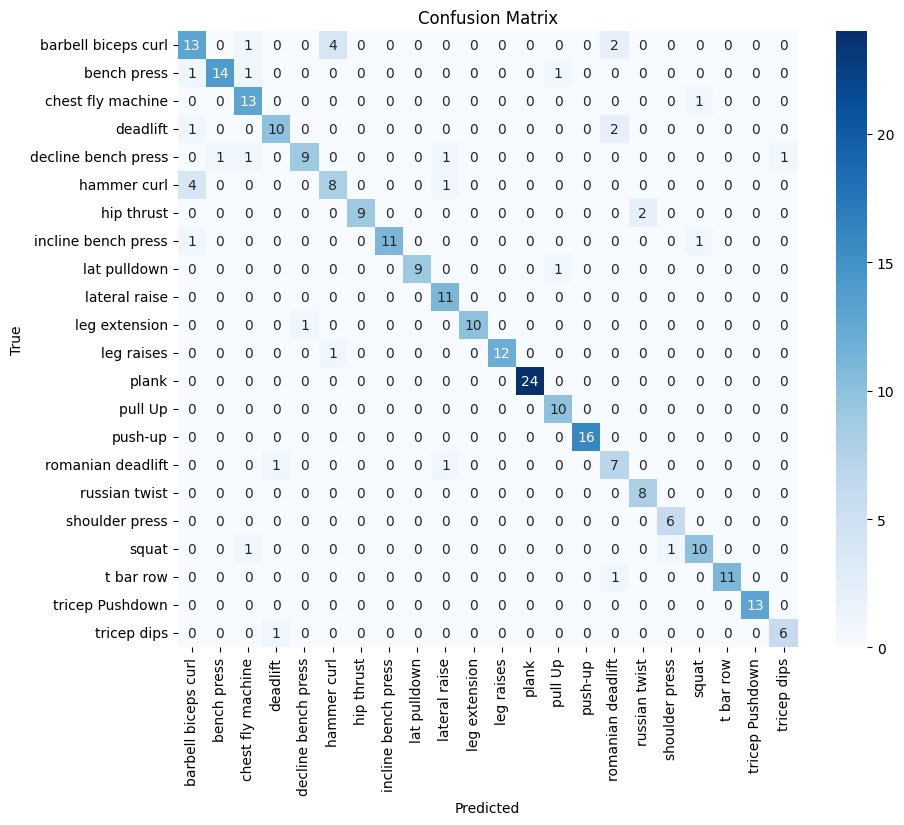

In [89]:
cm = confusion_matrix(y_true_labels_joints, y_pred_labels_joints, labels=le.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [90]:
# Fit another CNN model but with elbow angles
def angle_between_points(a, b, c):
    """Angle at point b between segments ab and bc (in degrees)"""
    ab = a - b
    cb = c - b
    cosine = np.dot(ab, cb) / (np.linalg.norm(ab) * np.linalg.norm(cb) + 1e-8)
    return np.degrees(np.arccos(np.clip(cosine, -1, 1)))

def compute_elbow_angles(sequence):
    """Input: (frames, 66) → Output: (frames, 2) with [left_elbow_angle, right_elbow_angle]"""
    seq = sequence.reshape(-1, 33, 2)
    angles = []

    for frame in seq:
        left_angle = angle_between_points(frame[11], frame[13], frame[15])  # left_shoulder → elbow → wrist
        right_angle = angle_between_points(frame[12], frame[14], frame[16])  # right_shoulder → elbow → wrist
        angles.append([left_angle, right_angle])

    return np.array(angles)  # shape: (frames, 2)

X_train_angles = np.array([compute_elbow_angles(seq) for seq in X_train])
X_train_angles = np.concatenate((X_train, X_train_angles), axis=-1)
X_val_angles = np.array([compute_elbow_angles(seq) for seq in X_val])
X_val_angles = np.concatenate((X_val, X_val_angles), axis=-1)

input_shape_angles = (X_train_angles.shape[1], X_train_angles.shape[2])
angles_model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=input_shape_angles),
    layers.Conv1D(128, 5, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),
    
    layers.Conv1D(128, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.3),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
callbacks = [tf.keras.callbacks.ModelCheckpoint('pose_model_angles.keras', save_best_only=True, monitor='val_loss', mode='min')]
angles_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = angles_model.fit(X_train_angles, y_train_enc, epochs=200, batch_size=32, validation_data=(X_val_angles, y_val_enc), callbacks=callbacks)

Epoch 1/200


/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0685 - loss: 5.9575 - val_accuracy: 0.1775 - val_loss: 2.9306
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1404 - loss: 2.8826 - val_accuracy: 0.2065 - val_loss: 2.6666
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1882 - loss: 2.6752 - val_accuracy: 0.2826 - val_loss: 2.4494
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2282 - loss: 2.5196 - val_accuracy: 0.3333 - val_loss: 2.1696
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2640 - loss: 2.3672 - val_accuracy: 0.3696 - val_loss: 2.0060
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3035 - loss: 2.2387 - val_accuracy: 0.3986 - val_loss: 1.9462
Epoch 7/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3403 - loss: 2.1553 - val_accuracy: 0.4638 - val_loss: 1.8336
Epoch 8/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3539 - loss: 1.9861 - val_accuracy: 0.4275 - val_loss: 1.

In [91]:
angles_model = models.load_model('pose_model_angles.keras')
y_val_pred_angles = angles_model.predict(X_val_angles)
y_val_pred_classes_angles = np.argmax(y_val_pred_angles, axis=1)
y_true_labels_angles = le.inverse_transform(y_val_enc)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [92]:
# compare the three models
accuracy = accuracy_score(y_val_enc, y_val_pred_classes)
print(f"Validation Accuracy: {accuracy:.2f}")

accuracy_joints = accuracy_score(y_val_enc, y_val_pred_classes_joints)
print(f"Validation Accuracy with Added Joint Features: {accuracy_joints:.2f}")

accuracy_angles = accuracy_score(y_val_enc, y_val_pred_classes_angles)
print(f"Validation Accuracy with Elbow Angles: {accuracy_angles:.2f}")

Validation Accuracy: 0.84
Validation Accuracy with Added Joint Features: 0.87
Validation Accuracy with Elbow Angles: 0.81


In [93]:
# Evaluate on test set
X_test_joints = np.array([extract_joint_features(seq) for seq in X_test])
X_test_joints = np.concatenate((X_test, X_test_joints), axis=-1)

joints_model = models.load_model('pose_model_joints.keras')
y_test_pred_joints = joints_model.predict(X_test_joints)
y_test_pred_classes_joints = np.argmax(y_test_pred_joints, axis=1)

accuracy_score = accuracy_score(y_test_enc, y_test_pred_classes_joints)
print(f"Test Accuracy with Joint Features: {accuracy_score:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Test Accuracy with Joint Features: 0.88


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


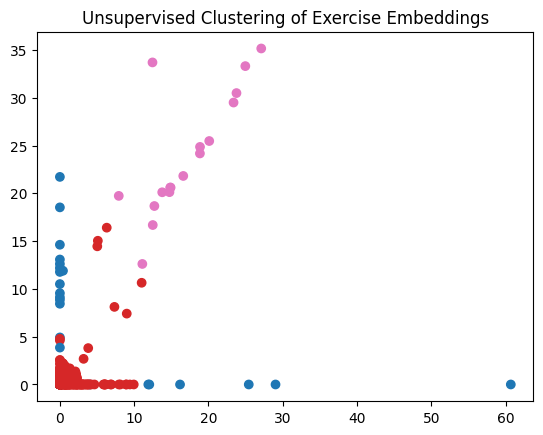

In [94]:
# Get penultimate layer output from the trained model
feature_model = tf.keras.Model(inputs=joints_model.input, outputs=joints_model.layers[-2].output)
X_embed = feature_model.predict(X_val_joints)

# Clustering
from sklearn.cluster import KMeans
cluster_labels = KMeans(n_clusters=4).fit_predict(X_embed)

# Visualize
import matplotlib.pyplot as plt
plt.scatter(X_embed[:, 0], X_embed[:, 1], c=cluster_labels, cmap='tab10')
plt.title("Unsupervised Clustering of Exercise Embeddings")
plt.show()


In [95]:
val.reset_index(drop=True, inplace=True)
df_clusters = pd.DataFrame({
    "cluster": cluster_labels,
    "true_label": le.inverse_transform(y_val_enc),
    "predicted_label": le.inverse_transform(y_val_pred_classes_joints),
    "video": val['video'],
    "index": val.index
})

In [96]:
# Look at the clusters
pd.crosstab(df_clusters["cluster"], df_clusters["true_label"])

true_label,barbell biceps curl,bench press,chest fly machine,deadlift,decline bench press,hammer curl,hip thrust,incline bench press,lat pulldown,lateral raise,...,plank,pull Up,push-up,romanian deadlift,russian twist,shoulder press,squat,t bar row,tricep Pushdown,tricep dips
cluster,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,4,3,8,0,...,0,0,0,0,5,0,6,0,0,2
1,20,17,14,12,13,13,7,10,2,11,...,7,10,16,9,3,6,6,12,13,5
2,0,0,0,0,0,0,0,0,0,0,...,17,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
# Which categories have samples not in cluster 0?
pd.crosstab(df_clusters[df_clusters["cluster"] != 0]["cluster"], df_clusters["true_label"])

true_label,barbell biceps curl,bench press,chest fly machine,deadlift,decline bench press,hammer curl,hip thrust,incline bench press,lat pulldown,lateral raise,...,plank,pull Up,push-up,romanian deadlift,russian twist,shoulder press,squat,t bar row,tricep Pushdown,tricep dips
cluster,,,,,,,,,,,,,,,,,,,,,
1,20,17,14,12,13,13,7,10,2,11,...,7,10,16,9,3,6,6,12,13,5
2,0,0,0,0,0,0,0,0,0,0,...,17,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# Which clusters have more than 1 label?
df_clusters.groupby("true_label")["cluster"].nunique().sort_values(ascending=False)

true_label
leg raises             2
incline bench press    2
squat                  2
russian twist          2
plank                  2
lat pulldown           2
tricep dips            2
hip thrust             2
deadlift               2
hammer curl            1
lateral raise          1
leg extension          1
bench press            1
decline bench press    1
pull Up                1
push-up                1
romanian deadlift      1
shoulder press         1
chest fly machine      1
t bar row              1
tricep Pushdown        1
barbell biceps curl    1
Name: cluster, dtype: int64

In [99]:
# Pull metadata to find plank videos
planks_df = df_clusters[df_clusters["true_label"] == "plank"]
planks_df

,cluster,true_label,predicted_label,video,index
2,1,plank,plank,pose_data/val/plank/09de5c17-291e-4ec8-881b-b8...,2
11,2,plank,plank,pose_data/val/plank/e0c636eb-593f-4221-aeee-9e...,11
29,2,plank,plank,pose_data/val/plank/a5b336a9-f0a1-4582-b957-82...,29
80,2,plank,plank,pose_data/val/plank/3fe46a43-37da-498e-86ec-81...,80
87,2,plank,plank,pose_data/val/plank/94edbe5a-afaa-47e0-972a-fd...,87
91,2,plank,plank,pose_data/val/plank/001a3533-4b19-457e-8c3b-92...,91
95,2,plank,plank,pose_data/val/plank/cf46cac8-93ed-487f-a913-83...,95
133,2,plank,plank,pose_data/val/plank/d6bb3fb8-684f-423c-90d2-70...,133
135,1,plank,plank,pose_data/val/plank/89e90863-db27-4f3e-bc42-12...,135
136,1,plank,plank,pose_data/val/plank/9f2cb2cb-bae8-4d7e-8d43-57...,136


In [100]:
def average_pose(sequences):
    """Compute the average pose over all frames in all sequences"""
    all_frames = np.concatenate(sequences, axis=0)  # shape: (total_frames, joints*2)
    return all_frames.mean(axis=0).reshape(-1, 2)   # shape: (joints, 2)

cluster_sequences = {}
for cluster_id in sorted(df_clusters["cluster"].unique()):
    indices = df_clusters[(df_clusters["true_label"] == "plank") & (df_clusters["cluster"] == cluster_id)].index
    sequences = [X_val_joints[i] for i in indices]
    cluster_sequences[cluster_id] = sequences


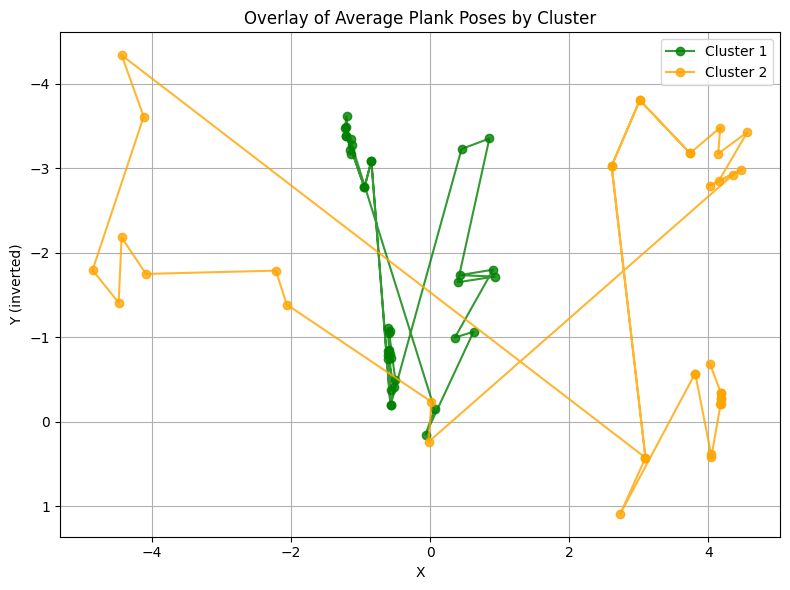

In [101]:
colors = ['blue', 'green', 'orange', 'red']
plt.figure(figsize=(8, 6))

for i, (cluster_id, sequences) in enumerate(cluster_sequences.items()):
    if not sequences:
        continue
    avg_pose = average_pose(sequences)
    plt.plot(avg_pose[:, 0], -avg_pose[:, 1], 'o-', label=f'Cluster {cluster_id}', color=colors[i], alpha=0.8)

plt.legend()
plt.title("Overlay of Average Plank Poses by Cluster")
plt.xlabel("X")
plt.ylabel("Y (inverted)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()
